# Backtest Set-up

## Boilerplate

In [1]:
import attrs, multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# plt.rcParams['figure.dpi'] = 200  # or any value like 300 for print-quality


## High-level Parameterization

In [2]:
@attrs.frozen(kw_only=True)
class Constants:
    ## From https://en.wikipedia.org/wiki/Trading_day
    annual_trading_days: int = 252
    
    ## Estimated from https://www.visualcapitalist.com/the-cost-of-space-flight/
    launch_cost_per_kg: int = 1_600

    ## From https://usafacts.org/answers/what-is-the-current-inflation-rate/country/united-states/
    estimated_inflation_rate: float = 0.028

    ## Estimated from ELA phases
    funding_requirement_fractions: list[float] = [.10, .2, .4, .15, .15]

    ## Snapshot, from https://fred.stlouisfed.org/series/FEDFUNDS
    fedfunds_rate = 0.0433

    ## Snapshot, from https://www.theblock.co/data/crypto-markets/prices/annualized-btc-volatility-30d
    annualized_volatility = 0.40

    ## Margin rate, using average of highest tier for BTC/USD derivatives exchanges
    ## NOTE: For simplicity, only using initial margin for highest tier
    margin_rate: float = attrs.Factory(lambda: round(np.mean([5.55, 7.65, 33.33, 13.5, 6, 40]), 2)/100.)
    
    def metric_tonne_water_launch_cost(self):
        return self.launch_cost_per_kg * 1_000

    def daily_volatility(self):
        return self.annualized_volatility / math.sqrt(self.annual_trading_days)

@attrs.frozen(kw_only=True)
class StudyParameters:
    constants: Constants = attrs.Factory(Constants)
    years_start_end: int = 5
    
    ## Study parameters
    num_consumers: int = 5
    num_intermediaries: int = 5
    num_space_companies: int = 5

    ## These are probability over the entirety of the simulation
    space_company_default_probability_pre_expiry: float = 0.1
    space_company_default_probability_post_expiry: float = 0.1
    space_company_total_desired_marketshare: float = 0.5
    space_company_total_max_daily_marketshare: float = 0.01
    space_company_trade_cooldown: int = 50 ## on AVERAGE, how long a cpty waits before trying to trade again

    ## Some VERY rough heuristics of market size
    water_required_single_artemis_mission = 100 ## Metric Tonnes
    consumers_artemis_frac_desired: float = [0.1, 0.1, 0.5, 0.5, 1.0]
    max_cash_avg_frac_per_intermediary: float = 2
    max_cash_avg_frac_per_intermediary_cpty_coefs: float = [0.5, 0.3, 0.2, 0.6, 0.7]

    def total_marketsz(self) -> int:
        return sum(self.water_required_single_artemis_mission * x for x in self.consumers_artemis_frac_desired)

    def total_initial_marketcap(self) -> float:
        return self.total_marketsz() * self.constants.metric_tonne_water_launch_cost()

    def max_adv(self) -> float:
        return self.total_marketsz() / (self.years_start_end * self.constants.annual_trading_days)

    # Simple market-impact model
    # see: https://bouchaud.substack.com/p/the-square-root-law-of-market-impact
    # here, we return the AVG price offset for the trade
    def market_impact(self, Q) -> float:
        daily_vol = self.constants.daily_volatility()
        halfway_px = 0.5
        return halfway_px * daily_vol * math.sqrt(Q / self.max_adv())

    ## Similarly rough heuristics for max capital a market maker can spend
    def getcash(self, mm_ind: int) -> float:
        coef = self.max_cash_avg_frac_per_intermediary * self.max_cash_avg_frac_per_intermediary_cpty_coefs[mm_ind]
        return self.total_initial_marketcap() * (1 / self.num_intermediaries) * coef
    
    ## Should be changed per-study
    rng_seed: int = 1
    rng: np.random.RandomState = attrs.Factory(lambda self: np.random.RandomState(self.rng_seed), takes_self=True)

    def __attrs_post_init__(self):
        print('post-init')
        assert len(self.consumers_artemis_frac_desired) == self.num_consumers

    def shuffle(self, arr):
        arr_ = arr[:]
        self.rng.shuffle(arr_)
        return arr_

In [3]:
P =StudyParameters(years_start_end=5)
print(P.total_marketsz())
print(P.getcash(0), P.getcash(1))
print(P.market_impact(100), P.market_impact(1000), P.market_impact(30), P.market_impact(55))
print(P.max_adv())
P

post-init
220.0
70400000.0 42240000.0
0.30151134457776363 0.9534625892455924 0.1651445647689541 0.22360679774997896
0.1746031746031746


StudyParameters(constants=Constants(annual_trading_days=252, launch_cost_per_kg=1600, estimated_inflation_rate=0.028, funding_requirement_fractions=[0.1, 0.2, 0.4, 0.15, 0.15], margin_rate=0.17670000000000002), years_start_end=5, num_consumers=5, num_intermediaries=5, num_space_companies=5, space_company_default_probability_pre_expiry=0.1, space_company_default_probability_post_expiry=0.1, space_company_total_desired_marketshare=0.5, space_company_total_max_daily_marketshare=0.01, space_company_trade_cooldown=50, consumers_artemis_frac_desired=[0.1, 0.1, 0.5, 0.5, 1.0], max_cash_avg_frac_per_intermediary=2, max_cash_avg_frac_per_intermediary_cpty_coefs=[0.5, 0.3, 0.2, 0.6, 0.7], rng_seed=1, rng=RandomState(MT19937) at 0x1B294657740)

## Simple time tracking

In [4]:
@attrs.define(kw_only=True)
class Clock:
    params: StudyParameters
    days: int = 0
    total_days: int = attrs.Factory(lambda self: int(self.params.years_start_end * self.params.constants.annual_trading_days), takes_self=True)

    def reset(self):
        self.days = 0

    def advance(self, amount=1):
        assert self.days < self.total_days
        self.days += amount

    def frac_thru(self):
        return self.days / self.total_days

    def year_in(self) -> int:
        return int(np.floor(self.days / self.params.constants.annual_trading_days))
    
    def get_correct_value(self, per_year_constants: list[float]) -> float:
        return per_year_constants[self.year_in()]

In [5]:
C = Clock(params=P)

for i, val in enumerate([11, 22, 33, 44, 55]):
    print(i, C.get_correct_value([11, 22, 33, 44, 55]), C.days, C.total_days)
    C.advance(251)

print(C.days, C.total_days)
C.reset()

0 11 0 1260
1 11 251 1260
2 22 502 1260
3 33 753 1260
4 44 1004 1260
1255 1260


## Benchmark price production

In [6]:
@attrs.frozen(kw_only=True)
class GeometricBrownianPricer:
    params: StudyParameters
    clock: Clock
    all_pricevals: list[float] = attrs.Factory(lambda self: self.generate(), takes_self=True)
    all_conventional_futures_pricevals: list[float] = attrs.Factory(lambda self: self.conventional_futures_prices(), takes_self=True)
    all_sharedrisk_futures_pricevals: list[float] = attrs.Factory(lambda self: self.sharedrisk_futures_prices(), takes_self=True)

    def conventional_futures_prices(self):
        """
        Reasonable approximation of a forward price for this contract.
        We just do benchmark price - the interest sell-side counterparty
        doesn't collect because buy-side counterparty holds the capital
        until delivery.

        NOTE: We do some silly approximations with interest rate per trading
        day, but should be fine as a first-order simplification. We also don't
        include margin posted
        """
        all_conventional_futures_pricevals = []
        for date, index_price in zip(range(self.clock.total_days), self.all_pricevals):
            remaining_days = self.clock.total_days - date
            interest_rate_daily_approx = (1 + self.params.constants.fedfunds_rate / self.params.constants.annual_trading_days)
            forward_price = index_price * (interest_rate_daily_approx ** remaining_days)
            all_conventional_futures_pricevals.append(forward_price)
        return all_conventional_futures_pricevals

    def sharedrisk_futures_prices(self):
        """
        Reasonable approximation of a counterparty risk-adjusted forward price for this contract.

        Unique pricing factors here are:
        - buy-side pays forward cost b/c its fully collateralized
        - counterparty risk default frac penalized price by px * frac

        NOTE: since we want our pricing to be position-independent for simulation simplicitiy, we don't include things
        like open interest + previous defaults etc. 
        """
        all_sharedrisk_futures_pricevals = []
        for date, index_price, forward_price in zip(range(self.clock.total_days), self.all_pricevals, self.all_conventional_futures_pricevals):
            forward_penalty = forward_price - index_price
            default_penalty = (1 - self.params.space_company_default_probability_pre_expiry) * (1 - self.params.space_company_default_probability_post_expiry)
            all_sharedrisk_futures_pricevals.append((index_price - forward_penalty) * default_penalty)
        return all_sharedrisk_futures_pricevals
    
    def generate(self):
        all_pricevals = []
        price_0 = self.params.constants.metric_tonne_water_launch_cost()
        sigma = self.params.constants.annualized_volatility
        mu = self.params.constants.estimated_inflation_rate
        timestep = 1 / self.params.constants.annual_trading_days
        random_preseed = self.params.rng.normal(0, 1, self.clock.total_days)

        prev_px = price_0
        for day in range(self.clock.total_days):
            new_px = prev_px * np.exp((mu - 0.5 * sigma ** 2) * timestep + sigma * np.sqrt(timestep) * random_preseed[day])
            all_pricevals.append(prev_px)
            prev_px = new_px
        return all_pricevals
    
    def price(self):
        return self.all_pricevals[self.clock.days], self.all_conventional_futures_pricevals[self.clock.days], self.all_sharedrisk_futures_pricevals[self.clock.days]

    def df(self, tag=''):
        return pd.DataFrame({'index_px'+tag : self.all_pricevals, 'conventional_px'+tag: self.all_conventional_futures_pricevals, 'sharedrisk_px'+tag: self.all_sharedrisk_futures_pricevals})

    def __repr__(self):
        return f'GBMP {len(self.all_pricevals)} prices'

middle (3461274.5769812125, 3619397.811497474, 2675552.5873966105)
middle (2301393.5090651186, 2406529.2841833956, 1778968.7644969418)
middle (1250306.299948399, 1307424.702977935, 966482.1965042789)


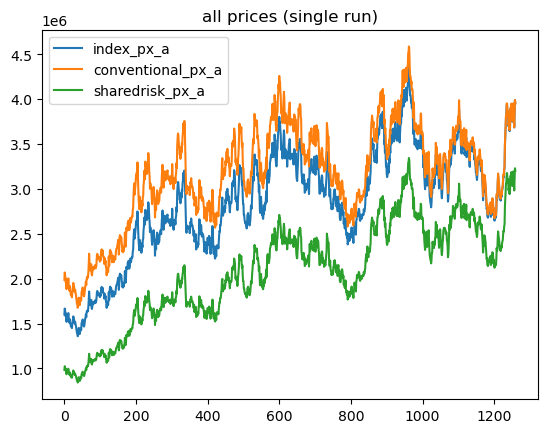

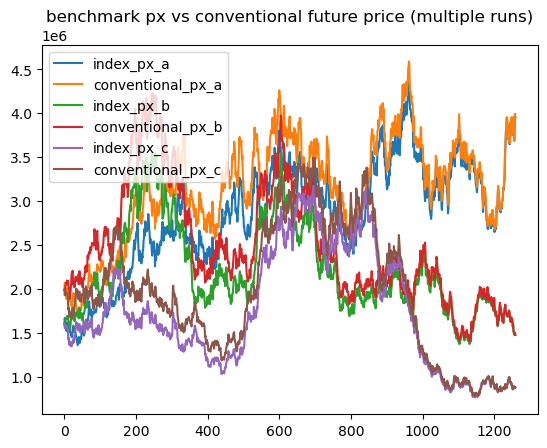

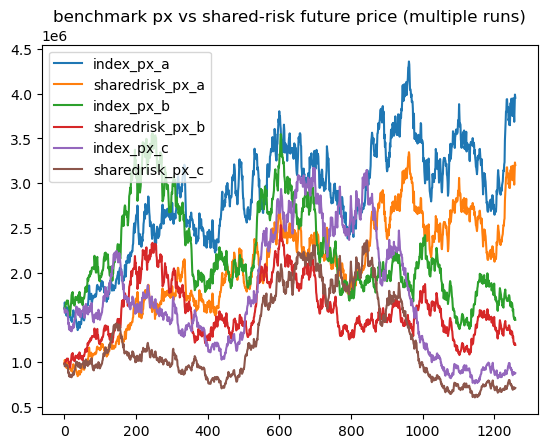

In [7]:
C.reset()
C.advance(1000)
pricer_dfs = []
for pricer in ['a', 'b', 'c']:
    pricer_class = GeometricBrownianPricer(clock=C, params=P)
    print('middle', pricer_class.price())
    pricer_dfs.append(pricer_class.df(tag=f'_'+pricer))
pd.concat(pricer_dfs[:1], axis=1).plot(title='all prices (single run)')
pd.concat(pricer_dfs, axis=1)[lambda _: [x for x in _.columns if 'index' in x or 'conv' in x]].plot(title='benchmark px vs conventional future price (multiple runs)')
pd.concat(pricer_dfs, axis=1)[lambda _: [x for x in _.columns if 'index' in x or 'shared' in x]].plot(title='benchmark px vs shared-risk future price (multiple runs)')

C.reset()

## Different types of counterparties

In [8]:
@attrs.define(kw_only=True)
class SpaceFundingCounterparty:
    index: int
    params: StudyParameters
    pricer: GeometricBrownianPricer
    sharedrisk_futures_sold: int = 0
    margin_currently_posted: float = 0
    cash_gained: float = 0
    in_default: bool = False
    amt_times_not_defaulted: int = 0
    next_allowed_to_sell: int = 0

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        return f'[sfc {self.state()}]'

    def target(self) -> int:
        return (self.params.total_marketsz() * self.params.space_company_total_desired_marketshare)
    
    def want_to_sell(self, today) -> int:
        if self.in_default:
            return 0
        if today < self.next_allowed_to_sell:
            return 0
        can_sell_by_max_daily = self.params.total_marketsz() * self.params.space_company_total_max_daily_marketshare * (2 * self.params.rng.random())
        remaining_in_target = self.target() - self.sharedrisk_futures_sold
        return max(int(min(can_sell_by_max_daily, remaining_in_target)), 0)

    def successfully_sold(self, amt, today):
        assert not self.in_default
        _, __, px = self.pricer.price()
        self.sharedrisk_futures_sold += amt
        self.margin_currently_posted += amt * px * self.params.constants.margin_rate
        self.cash_gained += amt * px * (1 - self.params.constants.margin_rate)
        self.next_allowed_to_sell = today + int(self.params.space_company_trade_cooldown * self.params.rng.random())

    def maybe_toggle_default(self):
        daily_default_probability = self.params.space_company_default_probability_pre_expiry / self.params.constants.annual_trading_days
        if P.rng.random() < daily_default_probability:
            print(self.index, 'defaulting!', self.amt_times_not_defaulted)
            self.in_default=True
        else:
            self.amt_times_not_defaulted += 1
        return self.in_default

    def state(self):
        tag = f'sfc_{self.index}'
        return {f'{tag}_cash' : self.cash_gained, f'{tag}_margin': self.margin_currently_posted,f'{tag}_sold': self.sharedrisk_futures_sold, f'{tag}_tgt' : self.target()}

In [9]:
sfc = SpaceFundingCounterparty(index=0, params=P, pricer=pricer_class)
print(sfc.state())
sfc.want_to_sell(0)

{'sfc_0_cash': 0, 'sfc_0_margin': 0, 'sfc_0_sold': 0, 'sfc_0_tgt': 110.0}


3

In [10]:
sfc.successfully_sold(3, 10)
sfc.next_allowed_to_sell

21

In [11]:
for i in range(0, 10000):
    sfc.maybe_toggle_default()

0 defaulting! 132
0 defaulting! 155
0 defaulting! 5046
0 defaulting! 6246
0 defaulting! 6567
0 defaulting! 7027


In [12]:
@attrs.define(kw_only=True)
class PurchaserCounterparty:
    index: int
    params: StudyParameters
    pricer: GeometricBrownianPricer
    
    pos: int = 0
    desired_pos: int = attrs.Factory(lambda self: self.params.consumers_artemis_frac_desired[self.index] * self.params.water_required_single_artemis_mission, takes_self=True)

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        return f'[pc {self.state()}]'
    
    def want_to_buy(self):
        return max(0, self.desired_pos - self.pos)

    def successfully_bought(self, amt):
        # print('updating', self.index, amt, self.pos)
        self.pos += amt

    def state(self):
        tag = f'pc_{self.index}'
        return {f'{tag}_pos' : self.pos, f'{tag}_maxp' : self.desired_pos} 

In [13]:
print(PurchaserCounterparty(index=0, params=P, pricer=pricer_class).state())
print(PurchaserCounterparty(index=0, params=P, pricer=pricer_class).want_to_buy())
print(PurchaserCounterparty(index=2, params=P, pricer=pricer_class).want_to_buy())

{'pc_0_pos': 0, 'pc_0_maxp': 10.0}
10.0
50.0


In [14]:
@attrs.define(kw_only=True)
class MarketMakerCounterparty:
    index: int
    params: StudyParameters
    pricer: GeometricBrownianPricer
    
    maxcash: float = attrs.Factory(lambda self: self.params.getcash(self.index), takes_self=True)
    
    sharedrisk_position: int = 0
    sharedrisk_cash_outlay: float = 0

    conventional_position: int = 0
    conventional_cash_outlay: float = 0

    profit: float = 0

    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        return f'[mm {self.state()}]'
   
    def arb(self, sharedrisk_for_sale, conventional_to_buy) -> int:
        """
        Attempt to do a "basis-style" arb between the shared-risk and conventional 
        markets. This should always be doable assuming we have cash buffer,
        and ~someone wants to trade. 
        
        We solve for "arb quantity", defined as AQ:
        remaining_cash = p_sr_fut * AQ + p_cc_fut * AQ * margin_rate
        """
        remaining_cash = self.maxcash - (self.sharedrisk_cash_outlay + self.conventional_cash_outlay)
        if remaining_cash <= 0:
            return [0, 0]

        index_px, p_cc_fut, p_sr_fut = self.pricer.price()
        assert p_cc_fut > p_sr_fut
        available_shares = min(sharedrisk_for_sale, conventional_to_buy)
        allowed_arb_shares = min(int(remaining_cash / (p_cc_fut * self.params.constants.margin_rate + p_sr_fut)), available_shares)
        self.conventional_position += allowed_arb_shares
        self.sharedrisk_position += allowed_arb_shares
        self.conventional_cash_outlay += self.params.constants.margin_rate * p_cc_fut * allowed_arb_shares
        self.sharedrisk_cash_outlay += p_sr_fut * allowed_arb_shares
        self.profit += allowed_arb_shares * (p_cc_fut - p_sr_fut)

        return allowed_arb_shares

    def state(self):
        tag = f'mm_{self.index}'
        return {f'{tag}_srpos' : self.sharedrisk_position, f'{tag}_srcash' : self.sharedrisk_cash_outlay, f'{tag}_cvpos' : self.conventional_position, f'{tag}_cvcash': self.conventional_cash_outlay, f'{tag}_maxcash': self.maxcash, f'{tag}_profit': self.profit}

In [15]:
mm_ = MarketMakerCounterparty(index=0, params=P, pricer=pricer_class)
print(mm_.arb(100, 25))
print(mm_.state())
print(MarketMakerCounterparty(index=0, params=P, pricer=pricer_class).arb(100_000_000, 25_000_000))

25
{'mm_0_srpos': 25, 'mm_0_srcash': 24568920.257856864, 'mm_0_cvpos': 25, 'mm_0_cvcash': 8776335.543749005, 'mm_0_maxcash': 70400000.0, 'mm_0_profit': 25099079.42380133}
52


In [16]:
## Sanity check that the market makers can arb the whole desired quantity if necessary
total = P.total_marketsz()
for ind in range(0, P.num_intermediaries):
    mm = MarketMakerCounterparty(index=ind, params=P, pricer=pricer_class)
    attempt = mm.arb(total, total)
    total -= attempt
    print(attempt, total)

52 168.0
31 137.0
21 116.0
63 53.0
53.0 0.0


## Backtest runner

In this section, we take a variety of counterparties, and allow them to make a decision once a day. We do this in the following process:

1. Space companies flip to see if they will default, and if not post any shares they want to on the exchange.
2. Consumer counterparties post their orders for how much they want to purchase.
3. Market makers (in a random order, decided per-day) get to decide to trade against both sets of counterparties, subject to their capital constraints.

NOTE: The above process is not meant to simulate a real, nor efficent, market, simply to provide a reasonable-enough structure to generate a large amount of synthetic portfolios on which to simulate default + liquidation

In [17]:
@attrs.define(kw_only=True)
class Runner:
    params: StudyParameters
    records: list = attrs.Factory(list)
    clock: Clock = attrs.Factory(lambda self: Clock(params=self.params), takes_self=True)
    pricer: GeometricBrownianPricer = attrs.Factory(lambda self: GeometricBrownianPricer(params=self.params, clock=self.clock), takes_self=True)
    ran: bool = False

    ## Counterparties
    mm: list = attrs.Factory(lambda self: [MarketMakerCounterparty(index=ind, params=self.params, pricer=self.pricer) for ind in range(0, self.params.num_intermediaries)], takes_self=True)
    sc: list = attrs.Factory(lambda self: [SpaceFundingCounterparty(index=ind, params=self.params, pricer=self.pricer) for ind in range(0, self.params.num_space_companies)], takes_self=True)
    pc: list = attrs.Factory(lambda self: [PurchaserCounterparty(index=ind, params=self.params, pricer=self.pricer) for ind in range(0, self.params.num_space_companies)], takes_self=True)

    def run_one_day(self, today):
        ## Track defaults
        # for cpty in self.sc:
        #    cpty.maybe_toggle_default()
        ## Find sells
        cpty_wts = [cpty.want_to_sell(today) for cpty in self.sc] 
        wts = sum(cpty_wts)
        ## Find buys
        wtb = sum(cpty.want_to_buy() for cpty in self.pc)
        ## Let market makers interact
        trades = []
        for cpty in self.params.shuffle(self.mm):
            trade = cpty.arb(wts, wtb)
            wts -= trade
            wtb -= trade
            if trade > 0:
                trades.append(trade)
        ## Assign shares out to sell-side counterparties
        available_for_space_companies = sum(trades)
        for cpty, amt in self.params.shuffle(list(zip(self.sc, cpty_wts))):
            if amt:
                company_got = min(amt, available_for_space_companies)
                cpty.successfully_sold(company_got, today)
                available_for_space_companies -= company_got
        ## Assign shares out to buy-side counterparties
        available_for_space_consumers = sum(trades)
        for cpty in self.params.shuffle(self.pc):
            amt = cpty.want_to_buy()
            if amt:
                company_got = min(amt, available_for_space_consumers)
                cpty.successfully_bought(company_got)
                available_for_space_consumers -= company_got
        return trades
    
    def run_and_store(self, today):
        # print('running day')
        trades = self.run_one_day(today)
        record = {'ntrades': len(trades), 'shares': sum(trades), 'benchmark_px': self.pricer.price()[0], 'cc_future_px': self.pricer.price()[1], 'sr_future_px': self.pricer.price()[2]}
        for cpty in self.sc + self.pc + self.mm:
            record |= cpty.state()
        self.records.append(record)

    def run(self):
        assert not self.ran
        while self.clock.days < self.clock.total_days:
            self.run_and_store(self.clock.days)
            self.clock.advance()
        self.ran = True

    def df(self):
        return pd.DataFrame.from_records(self.records)

In [18]:
runner = Runner(params=StudyParameters(max_cash_avg_frac_per_intermediary=2, space_company_default_probability_pre_expiry=0.001, years_start_end=5))
runner.run()

post-init


In [19]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
row = runner.df().head(50).tail(1)

In [20]:
assert runner.df().tail(1)[[x for x in row if '_pos' in x]].sum().sum() == runner.df().shares.sum()

In [21]:
row

,ntrades,shares,benchmark_px,cc_future_px,sr_future_px,sfc_0_cash,sfc_0_margin,sfc_0_sold,sfc_0_tgt,sfc_1_cash,sfc_1_margin,sfc_1_sold,sfc_1_tgt,sfc_2_cash,sfc_2_margin,sfc_2_sold,sfc_2_tgt,sfc_3_cash,sfc_3_margin,sfc_3_sold,sfc_3_tgt,sfc_4_cash,sfc_4_margin,sfc_4_sold,sfc_4_tgt,pc_0_pos,pc_0_maxp,pc_1_pos,pc_1_maxp,pc_2_pos,pc_2_maxp,pc_3_pos,pc_3_maxp,pc_4_pos,pc_4_maxp,mm_0_srpos,mm_0_srcash,mm_0_cvpos,mm_0_cvcash,mm_0_maxcash,mm_0_profit,mm_1_srpos,mm_1_srcash,mm_1_cvpos,mm_1_cvcash,mm_1_maxcash,mm_1_profit,mm_2_srpos,mm_2_srcash,mm_2_cvpos,mm_2_cvcash,mm_2_maxcash,mm_2_profit,mm_3_srpos,mm_3_srcash,mm_3_cvpos,mm_3_cvcash,mm_3_maxcash,mm_3_profit,mm_4_srpos,mm_4_srcash,mm_4_cvpos,mm_4_cvcash,mm_4_maxcash,mm_4_profit
49,0,0,1.510129e+06,1.859407e+06,1.043721e+06,5.318522e+06,1.141483e+06,6,110.0,4.400056e+06,944358.027877,5,110.0,1.770178e+06,379922.788296,2,110.0,4.380511e+06,940163.165032,5,110.0,3.421063e+06,734242.479628,4,110.0,4.0,10.0,10.0,10.0,4.0,50.0,2.0,50.0,2.0,100.0,5,5.112540e+06,5,1.621547e+06,70400000.0,4.064295e+06,1,1.030882e+06,1,327437.931825,42240000.0,822190.806865,1,1.119219e+06,1,359853.474808,28160000.0,917303.354632,12,1.298043e+07,12,4.171778e+06,84480000.0,1.062895e+07,3,3.187425e+06,3,1.013329e+06,98560000.0,2.547319e+06


## Simple backtest summary
need to get this a bit calibrated here

In [22]:
%run utils.py 

def summary_frame(df, params, ultralight_sfc=True, ultralight_mm=True, ultralight_pc=True, attribute_cash=False, add_default_cols=False) -> pd.DataFrame:
    df = df.copy()
    ## Add MM summary cols
    mm_inds = [int(x.split('_')[1]) for x in df.columns if 'cvcash' in x]
    df['mm_cashpos'] = 0
    df['mm_maxcash'] = 0
    df['cum_shares_traded'] = df['shares'].cumsum()
    df['cum_ntnl_invested'] = (df['shares'] * df.cc_future_px).cumsum()
    summary_cols = []
    default_cols = []
    if add_default_cols:
        ultralight_cols = ['sr_future_px', 'cc_future_px', 'cum_shares_traded', 'cum_ntnl_invested']
    else:
        ultralight_cols = ['benchmark_px', 'cum_shares_traded', 'cum_ntnl_invested']
    df['mm_profit'] = 0
    for mm in mm_inds:
        df[f'mm_{mm}_cashpos'] = df[f'mm_{mm}_srcash'] + df[f'mm_{mm}_cvcash']
        df['mm_cashpos'] += df[f'mm_{mm}_cashpos']
        df['mm_maxcash'] += df[f'mm_{mm}_maxcash']
        df['mm_profit'] += df[f'mm_{mm}_profit']
        if not ultralight_mm:
            summary_cols.append(f'mm_{mm}_cashpos')
            summary_cols.append(f'mm_{mm}_maxcash')
    if ultralight_mm:
        ultralight_cols.extend(['mm_cashpos', 'mm_maxcash'])

    ## Add sfc summary cols + default candidate columns
    sfc_inds = [int(x.split('_')[1]) for x in df.columns if '_sold' in x]
    df['sfc_currsold'] = 0
    df['sfc_tgtsold'] = 0
    df['sfc_totalcash'] = 0
    df['sfc_margin'] = 0
    df['d_candidate'] = df.index % max(sfc_inds)
    df['d_sold'] = df.apply(lambda row: row[f'sfc_{int(row.d_candidate)}_sold'], axis=1)
    df['d_margin'] = df.apply(lambda row: row[f'sfc_{int(row.d_candidate)}_margin'], axis=1)
    df['d_impact'] = df.apply(lambda row: params.market_impact(row[f'sfc_{int(row.d_candidate)}_sold']), axis=1)
    for sfc in sfc_inds:
        df['sfc_currsold'] += df[f'sfc_{sfc}_sold']
        df['sfc_tgtsold'] += df[f'sfc_{sfc}_tgt']
        df['sfc_totalcash'] += df[f'sfc_{sfc}_cash']
        df['sfc_margin'] += df[f'sfc_{sfc}_margin']
        if not ultralight_sfc:
            summary_cols.append(f'sfc_{sfc}_sold')
            summary_cols.append(f'sfc_{sfc}_tgt')
    if ultralight_sfc:
        ultralight_cols.extend(['sfc_currsold', 'sfc_tgtsold'])
    if add_default_cols:
        default_cols.extend(['d_candidate', 'd_sold', 'd_margin', 'd_impact'])

    ## Add pc summary cols
    pc_inds = [int(x.split('_')[1]) for x in df.columns if '_maxp' in x]
    df['pc_currbought'] = 0
    df['pc_tgtbought'] = 0
    for pc in pc_inds:
        df['pc_currbought'] += df[f'pc_{pc}_pos']
        df['pc_tgtbought'] += df[f'pc_{pc}_maxp']
        if not ultralight_pc:
            summary_cols.append(f'pc_{pc}_pos')
            summary_cols.append(f'pc_{pc}_maxp')
    if ultralight_pc:
        ultralight_cols.extend(['pc_currbought', 'pc_tgtbought'])
    if attribute_cash:
        ultralight_cols.extend(['sfc_totalcash', 'sfc_margin', 'mm_profit'])
    return df[ultralight_cols + summary_cols + default_cols]

In [23]:
hf(summary_frame(runner.df(), runner.params, ultralight_sfc=True, attribute_cash=True, add_default_cols=True))

,sr_future_px,cc_future_px,cum_shares_traded,cum_ntnl_invested,mm_cashpos,mm_maxcash,sfc_currsold,sfc_tgtsold,pc_currbought,pc_tgtbought,sfc_totalcash,sfc_margin,mm_profit,d_candidate,d_sold,d_margin,d_impact
0,1.1M,2.0M,11,21.9M,15.9M,323.8M,11,550.0,11.0,220.0,9.9M,2.1M,9.9M,0,3.0,578.3K,0.1
1,1.1M,2.1M,11,21.9M,15.9M,323.8M,11,550.0,11.0,220.0,9.9M,2.1M,9.9M,1,4.0,771.0K,0.1
2,1.1M,2.0M,12,23.9M,17.3M,323.8M,12,550.0,12.0,220.0,10.8M,2.3M,10.8M,2,1.0,197.8K,0.0
3,1.1M,2.0M,12,23.9M,17.3M,323.8M,12,550.0,12.0,220.0,10.8M,2.3M,10.8M,3,2.0,385.5K,0.0
4,1.1M,2.0M,12,23.9M,17.3M,323.8M,12,550.0,12.0,220.0,10.8M,2.3M,10.8M,0,3.0,578.3K,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2
1256,3.3M,3.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,0,38.0,10.8M,0.2
1257,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,1,30.0,7.5M,0.2
1258,3.6M,4.0M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,2,31.0,8.7M,0.2


## Simulate defaults
For each default, we do the following:
- Trade out of position using all of default_margin, and frac of sfc_margin. For the first version of this, we will do the repurchase NOT accounting for any type of market impact
- Socialize remaining loss on mm counterparties

In [24]:
import collections, functools

In [25]:
def gen_n_defaults(df, counterparties=1, seed=12_22_33, params=None):
    rng = np.random.default_rng(seed)
    df = summary_frame(df, params=params,ultralight_sfc=True, attribute_cash=True, add_default_cols=True)
    candidates = list(df.d_candidate.unique())
    rng.shuffle(candidates)
    rows = []
    for i in range(0, counterparties):
        candidate = candidates[i]
        candidate_rows = df[df.d_candidate == candidate].index.to_list()
        rng.shuffle(candidate_rows)
        rows.append(candidate_rows[0])
    return rows

In [26]:
def recursive_global_mgn_impl(row, prev_row, frac):
    """
    This implements the global_mgn_avail column in a recursive way, where the margin avail for a row is defined as follows:

    qty_needed[row] = d_sold[row] - d_local_mgn[row]
    mgn_avail[row] = sfc_margin[row] - tot_margin_used[prev]
    d_global_mgn[row] = min(mgn_avail[row] * frac / sr_future_px[row], qty_needed[row])
    tot_margin_used[row] = tot_margin_used[prev] + (d_local_mgn[row] + d_global_mgn[row]) * sr_future_px[row]
    """
    # print(prev_row)
    if prev_row:
        cum_mgn_used_prev = prev_row['cum_mgn_used']
    else:
        cum_mgn_used_prev = 0
    if not row['did_default']:
        return {'d_global_mgn' : 0, 'd_local_mgn': 0, 'cum_mgn_used': cum_mgn_used_prev, 'mgn_avail': 0, 'local_mgn_used': 0}
    
    # First compute the local margin case. Here we do a simplification that if 
    # global margin is remaining, we attribute it to the local margin pool.
    sr_impact_px = row['sr_future_px'] + row['sr_future_px'] * row['d_impact']
    local_margin_avail = min(row['sfc_margin'] - cum_mgn_used_prev, row['d_margin'])
    # print(local_margin_avail, sr_impact_px, row['d_sold'])
    d_local_mgn = min(local_margin_avail / sr_impact_px, row['d_sold'])
    qty_needed = row['d_sold'] - d_local_mgn
    local_mgn_used = d_local_mgn * sr_impact_px
    
    # Then, we use up to "frac" of the global margin to settle remaining balance
    mgn_avail = row['sfc_margin'] - cum_mgn_used_prev - local_mgn_used
    d_global_mgn = min(mgn_avail * frac / sr_impact_px, qty_needed)
    cum_mgn_used = cum_mgn_used_prev + (d_global_mgn + d_local_mgn) * sr_impact_px
    return {'d_global_mgn' : d_global_mgn, 'cum_mgn_used' : cum_mgn_used, 'mgn_avail' : mgn_avail, 'd_local_mgn': d_local_mgn, 'local_mgn_used': local_mgn_used}
        

def simulate_defaults(df, rows, params, frac=0.2):
    df = df.copy()
    assert 0 not in rows, "easier to not support this"
    # Compute simple default tagger
    df = summary_frame(df, params=params, ultralight_sfc=True, attribute_cash=True, add_default_cols=True)
    df['did_default'] = [(x in rows) for x in list(df.index)]
    default_counts = collections.Counter(df[df.did_default].d_candidate)
    assert max(default_counts.values()) == 1, "candidate can't default twice: "+str(default_counts)
    # Compute how much of their shares were able to be traded out via some "frac" of the total shared margin, or local margin
    df = add_recursive_cols(df, functools.partial(recursive_global_mgn_impl, frac=frac))
    # Compute remaining tradeout which is "socialized" to the buyers
    df['d_soc'] = np.where(df.did_default, df.d_sold - df.d_global_mgn - df.d_local_mgn, 0)
    # Compute default loss to other counterparties (mm and sfc)
    # Assume MM has to replace lost shares on the conventional market
    df['d_loss_mm'] = df.d_soc * (df.cc_future_px * (1 + df.d_impact))
    df['d_loss_sfc'] = df.d_global_mgn * (df.sr_future_px * (1 + df.d_impact))
    # Remove intermediate columns
    # del df['global_mgn_avail']
    # del df['local_mgn_used']
    # Sanity-check
    assert (df.d_soc.sum() + df.d_local_mgn.sum() + df.d_global_mgn.sum()) - df[df.did_default].d_sold.sum() < 1e-4
    return df

In [27]:
## TEST CASE -- first default clears out all of the margin, second default is entirely on the mms
dd = simulate_defaults(runner.df(), [800, 805], runner.params, frac=1)
dd_hf = hf(dd)
hf(dd.loc[799:810])

,sr_future_px,cc_future_px,cum_shares_traded,cum_ntnl_invested,mm_cashpos,mm_maxcash,sfc_currsold,sfc_tgtsold,pc_currbought,pc_tgtbought,sfc_totalcash,sfc_margin,mm_profit,d_candidate,d_sold,d_margin,d_impact,did_default,d_global_mgn,d_local_mgn,cum_mgn_used,mgn_avail,local_mgn_used,d_soc,d_loss_mm,d_loss_sfc
799,2.1M,2.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
800,2.0M,2.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,0,38.0,10.8M,0.2,True,13.4,4.5,43.3M,32.5M,10.8M,20.1,63.7M,32.5M
801,2.1M,2.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,1,30.0,7.5M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
802,2.1M,2.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,2,31.0,8.7M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
803,2.0M,2.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
804,2.0M,2.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,0,38.0,10.8M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
805,2.0M,2.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,1,30.0,7.5M,0.2,True,0.0,0.0,43.3M,0.0,0.0,30.0,93.0M,0.0
806,2.0M,2.6M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,2,31.0,8.7M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
807,2.0M,2.6M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
808,2.1M,2.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,0,38.0,10.8M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0


In [28]:
assert len(dd[dd_hf.d_local_mgn != '0.0']) == 1
assert len(dd[dd_hf.d_local_mgn != '0.0']) == 1
dd_hf.tail(10)

,sr_future_px,cc_future_px,cum_shares_traded,cum_ntnl_invested,mm_cashpos,mm_maxcash,sfc_currsold,sfc_tgtsold,pc_currbought,pc_tgtbought,sfc_totalcash,sfc_margin,mm_profit,d_candidate,d_sold,d_margin,d_impact,did_default,d_global_mgn,d_local_mgn,cum_mgn_used,mgn_avail,local_mgn_used,d_soc,d_loss_mm,d_loss_sfc
1250,3.5M,3.9M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,2,31.0,8.7M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
1251,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
1252,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,0,38.0,10.8M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
1253,3.5M,4.0M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,1,30.0,7.5M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
1254,3.5M,3.9M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,2,31.0,8.7M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
1255,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
1256,3.3M,3.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,0,38.0,10.8M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
1257,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,1,30.0,7.5M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
1258,3.6M,4.0M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,2,31.0,8.7M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0
1259,3.6M,4.0M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2,False,0.0,0.0,43.3M,0.0,0.0,0.0,0.0,0.0


In [29]:
## TEST CASE -- first default clears out some of the margin, second default is still shared between three cptys
dd2 = simulate_defaults(runner.df(), [1255, 1257], runner.params, frac=0.5)
dd_hf2 = hf(dd2)
assert len(dd2[dd_hf2.d_local_mgn != '0.0']) == 2
assert len(dd2[dd_hf2.d_local_mgn != '0.0']) == 2
dd_hf2.tail(10)

,sr_future_px,cc_future_px,cum_shares_traded,cum_ntnl_invested,mm_cashpos,mm_maxcash,sfc_currsold,sfc_tgtsold,pc_currbought,pc_tgtbought,sfc_totalcash,sfc_margin,mm_profit,d_candidate,d_sold,d_margin,d_impact,did_default,d_global_mgn,d_local_mgn,cum_mgn_used,mgn_avail,local_mgn_used,d_soc,d_loss_mm,d_loss_sfc
1250,3.5M,3.9M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,2,31.0,8.7M,0.2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1251,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1252,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,0,38.0,10.8M,0.2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1253,3.5M,4.0M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,1,30.0,7.5M,0.2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1254,3.5M,3.9M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,2,31.0,8.7M,0.2,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1255,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2,True,4.4,2.1,25.8M,35.1M,8.3M,25.5,113.5M,17.5M
1256,3.3M,3.7M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,0,38.0,10.8M,0.2,False,0.0,0.0,25.8M,0.0,0.0,0.0,0.0,0.0
1257,3.4M,3.8M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,1,30.0,7.5M,0.2,True,1.3,1.9,38.3M,10.1M,7.5M,26.9,119.9M,5.0M
1258,3.6M,4.0M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,2,31.0,8.7M,0.2,False,0.0,0.0,38.3M,0.0,0.0,0.0,0.0,0.0
1259,3.6M,4.0M,164,413.5M,318.1M,323.8M,164,550.0,164.0,220.0,201.8M,43.3M,168.4M,3,32.0,8.3M,0.2,False,0.0,0.0,38.3M,0.0,0.0,0.0,0.0,0.0


In [30]:
def score(df, default_df):
    score = {}
    last = default_df.iloc[-1]
    score['mm_profit'] = last.mm_profit - default_df.d_loss_mm.sum()
    score['sfc_funding_acquired'] = last.sfc_totalcash - default_df.d_loss_sfc.sum()
    score['ntnl_invested'] = last.cum_ntnl_invested
    score['worst_mm_loss'] = default_df.d_loss_mm.max()
    score['last_day_traded'] = df[df.ntrades != 0].iloc[-1].name
    return score

score(runner.df(), dd2)

{'mm_profit': -65019522.22280529,
 'sfc_funding_acquired': 179210572.5082647,
 'ntnl_invested': 413470868.42796373,
 'worst_mm_loss': 119908928.71056803,
 'last_day_traded': 408}

# Compute some metrics! 

## Average mm_profit, sfc_totalcash in (1,2)-default situations

In [97]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_funding_vs_profit(df, tag):
    plt.figure(figsize=(6, 4))
    v = df['mm_profit']
    max_abs = np.max(np.abs(v))
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", ["red", "#b0c4de", "green"])
    plt.scatter(df['sfc_funding_acquired'] / 1e6, v / 1e6, c=v, cmap=cmap, norm=norm, alpha=0.7)
    plt.xlabel("SFC Funding Acquired ($M)")
    plt.ylabel("MM Profit ($M)")
    plt.title(f"Funding vs Profit{tag}")
    plt.tight_layout()
    plt.show()

In [87]:
@functools.cache
def runner_cached(seed):
    runner = Runner(params=StudyParameters(max_cash_avg_frac_per_intermediary=2, space_company_default_probability_pre_expiry=0.001, years_start_end=5, rng_seed=seed))
    runner.run()
    return runner

@functools.cache
def run(seed, num_defaults, num_default_rounds, frac=0.2):
    default_outcomes = []
    df = runner.df()
    for d_seed in range(num_default_rounds):
        defaults = gen_n_defaults(df, num_defaults, params=runner.params, seed=d_seed)
        default_df = simulate_defaults(runner.df(), defaults, runner.params, frac=frac)
        default_outcomes.append(score(runner.df(), default_df))
    return pd.DataFrame.from_records(default_outcomes)

In [88]:
## quick determinism check
assert (run(110, 1, 10, frac=0.5) - run(110, 1, 10, frac=0.5)).abs().max().max() < 1e-6

In [89]:
random.seed(123)  # fixed seed for determinism
seeds = random.sample(range(1, 10000), 20)
print(seeds)

def run_and_plot(n_defaults):
    data = []
    for seed in seeds:
        data.append(run(seed, n_defaults, 50, frac=0.2))
    plot_funding_vs_profit(pd.concat(data), tag=f' ({n_defaults}-default scenario)')    

[858, 4386, 1429, 6673, 4368, 1765, 626, 6212, 8786, 9214, 5443, 5584, 851, 2616, 2213, 5525, 9191, 5469, 4017, 2684]


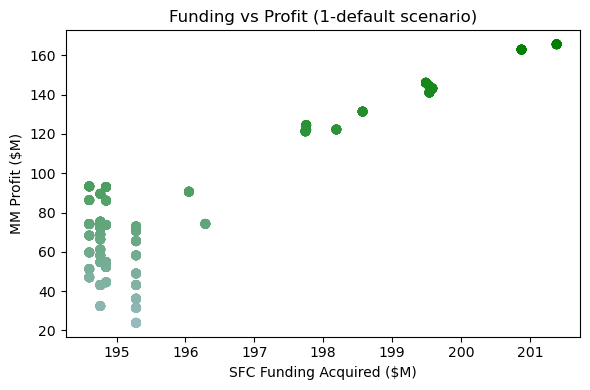

In [98]:
run_and_plot(1)

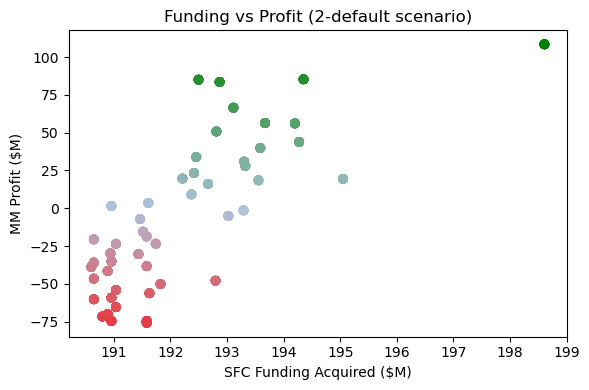

In [99]:
run_and_plot(2)

## Max single MM loss as a function of how much global margin is allocated to a single liquidation

In [58]:
data2 = []
seed_ = [110, 858]
frac_values = np.linspace(0.05, 1.0, 101).round(4).tolist()
for frac in frac_values:
    data2.append([frac, run(seed_, 2, num_default_rounds=20, frac=frac)])

In [59]:
records = []
for frac, df in data2:
    for row_ind in range(len(df)):
        records.append({'frac' : frac, 'worst_mm_loss': df.iloc[row_ind].worst_mm_loss})

In [70]:
df = pd.DataFrame.from_records(records)

### Linear fit + correlation

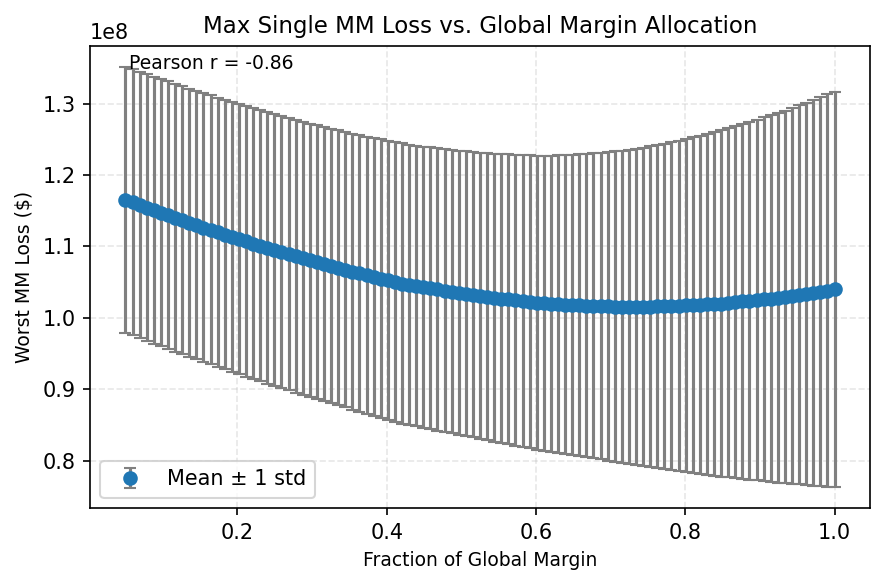

In [78]:
from scipy.stats import pearsonr

def plot_frac_w_error_bars(df):
    grouped = df.groupby('frac')['worst_mm_loss'].agg(['mean', 'std']).reset_index()
    plt.figure(figsize=(6, 4), dpi=150)
    plt.errorbar(
        grouped['frac'],
        grouped['mean'],
        yerr=grouped['std'],
        fmt='o',
        ecolor='gray',
        capsize=3,
        label='Mean ± 1 std'
    )
    plt.title("Max Single MM Loss vs. Global Margin Allocation", fontsize=11)
    plt.xlabel("Fraction of Global Margin", fontsize=9)
    plt.ylabel("Worst MM Loss ($)", fontsize=9)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    return grouped

plot_frac_w_error_bars(df)
corr, _ = pearsonr(grouped['frac'], grouped['mean'])

# Annotate correlation
plt.annotate(f"Pearson r = {corr:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=9)

plt.tight_layout()
plt.show()

### Non-linear fit

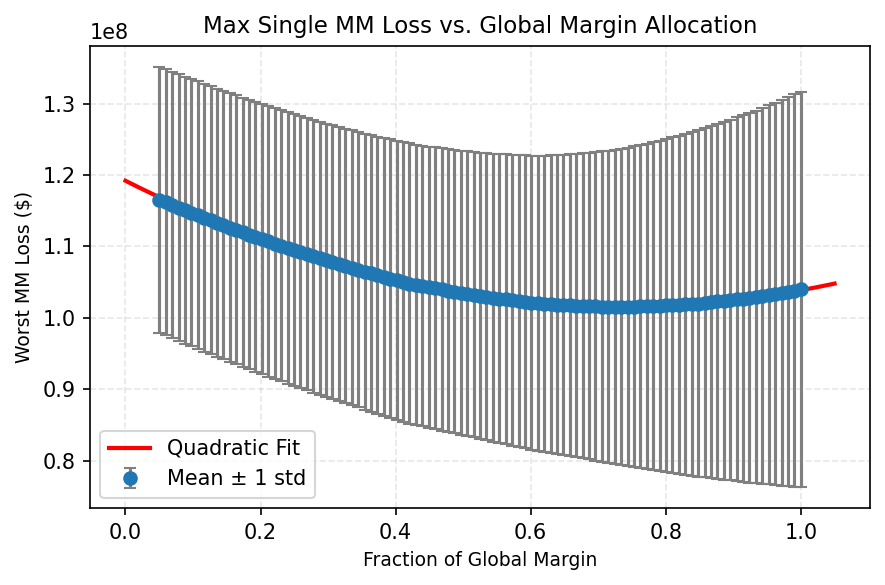

In [82]:
# Fit polynomial
grouped = plot_frac_w_error_bars(df)
coeffs = np.polyfit(grouped['frac'], grouped['mean'], deg=2)
poly_func = np.poly1d(coeffs)

# Generate dense x-axis for curve
x_fit = np.linspace(grouped['frac'].min() - 0.05, grouped['frac'].max() + 0.05, 500)
y_fit = poly_func(x_fit)

plt.plot(x_fit, y_fit, color='red', linewidth=2.0, label='Quadratic Fit')
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()